In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skimage.io import imread
from skimage.transform import downscale_local_mean
from os.path import join
from tqdm import tqdm_notebook
#import cv2
from sklearn.cross_validation import train_test_split
%matplotlib inline

# Specify Input Folder #
input_folder = '/Users/mtetkosk/Google Drive/Data Science/Carvana/data/raw/'

# Load the mask csv files #
df_mask = pd.read_csv(join(input_folder, 'train_masks.csv'), usecols=['img'])

# Gather the ids from the df_mask df
ids_train = df_mask['img'].map(lambda s: s.split('_')[0]).unique()

# Each car has 16 images, this is a counter to cycle thru the images
imgs_idx = list(range(1, 17))

In [19]:
# Define lambda functions
load_img = lambda im, idx: imread(join(input_folder, 'train', '{}_{:02d}.jpg'.format(im, idx)))
load_mask = lambda im, idx: imread(join(input_folder, 'train_masks', '{}_{:02d}_mask.gif'.format(im, idx)))
resize = lambda im: downscale_local_mean(im, (4,4) if im.ndim==2 else (4,4,1))
mask_image = lambda im, mask: (im * np.expand_dims(mask, 2))

In [20]:
num_train = 150  # len(ids_train)

# Load data for position id=1
X = np.empty((num_train, 320, 480, 12), dtype=np.float32)
y = np.empty((num_train, 320, 480, 1), dtype=np.float32)

with tqdm_notebook(total=num_train) as bar:
    idx = 1 # Rotation index
    for i, img_id in enumerate(ids_train[:num_train]):
        imgs_id = [resize(load_img(img_id, j)) for j in imgs_idx]  # what type of structure is imgs_id?
        # Input is image + mean image per channel + std image per channel
        X[i, ..., :9] = np.concatenate([imgs_id[idx-1], np.mean(imgs_id, axis=0), np.std(imgs_id, axis=0)], axis=2)
        y[i] = resize(np.expand_dims(load_mask(img_id, idx), 2)) / 255.
        del imgs_id # Free memory
        bar.update()

In [21]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [22]:
# Concat overall y info to X
# This is important as the kernels of CNN used below has no information of its location
y_train_mean = y_train.mean(axis=0)
y_train_std = y_train.std(axis=0)
y_train_min = y_train.min(axis=0)

y_features = np.concatenate([y_train_mean, y_train_std, y_train_min], axis=2)

X_train[:, ..., -3:] = y_features
X_val[:, ..., -3:] = y_features

In [23]:
# Normalize input and output
X_mean = X_train.mean(axis=(0,1,2), keepdims=True)
X_std = X_train.std(axis=(0,1,2), keepdims=True)

X_train -= X_mean
X_train /= X_std

X_val -= X_mean
X_val /= X_std

In [24]:
# Create simple model
from keras.layers import Conv2D
from keras.models import Sequential
import keras.backend as K

model = Sequential()
model.add( Conv2D(16, 3, activation='relu', padding='same', input_shape=(320, 480, 12) ) )
model.add( Conv2D(32, 3, activation='relu', padding='same') )
model.add( Conv2D(1, 5, activation='sigmoid', padding='same') )

In [25]:
from keras.optimizers import Adam
from keras.losses import binary_crossentropy

smooth = 1.

# From here: https://github.com/jocicmarko/ultrasound-nerve-segmentation/blob/master/train.py
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)


def bce_dice_loss(y_true, y_pred):
    return 0.5 * binary_crossentropy(y_true, y_pred) - dice_coef(y_true, y_pred)

model.compile(Adam(lr=1e-3), bce_dice_loss, metrics=['accuracy', dice_coef])

In [26]:
history = model.fit(X_train, y_train, epochs=15, validation_data=(X_val, y_val), batch_size=5, verbose=2)

Train on 120 samples, validate on 30 samples
Epoch 1/15
209s - loss: -5.2510e-01 - acc: 0.8831 - dice_coef: 0.6578 - val_loss: -7.3690e-01 - val_acc: 0.9417 - val_dice_coef: 0.8214
Epoch 2/15
196s - loss: -7.9089e-01 - acc: 0.9559 - dice_coef: 0.8570 - val_loss: -8.0292e-01 - val_acc: 0.9585 - val_dice_coef: 0.8602
Epoch 3/15
204s - loss: -8.1799e-01 - acc: 0.9618 - dice_coef: 0.8751 - val_loss: -8.0264e-01 - val_acc: 0.9583 - val_dice_coef: 0.8616
Epoch 4/15
179s - loss: -8.2587e-01 - acc: 0.9634 - dice_coef: 0.8782 - val_loss: -8.2744e-01 - val_acc: 0.9633 - val_dice_coef: 0.8789
Epoch 5/15
332s - loss: -8.3415e-01 - acc: 0.9648 - dice_coef: 0.8840 - val_loss: -8.2863e-01 - val_acc: 0.9634 - val_dice_coef: 0.8804
Epoch 6/15
179s - loss: -8.3817e-01 - acc: 0.9657 - dice_coef: 0.8872 - val_loss: -8.2811e-01 - val_acc: 0.9634 - val_dice_coef: 0.8813
Epoch 7/15
184s - loss: -8.3663e-01 - acc: 0.9651 - dice_coef: 0.8873 - val_loss: -8.2729e-01 - val_acc: 0.9638 - val_dice_coef: 0.8761
Epo

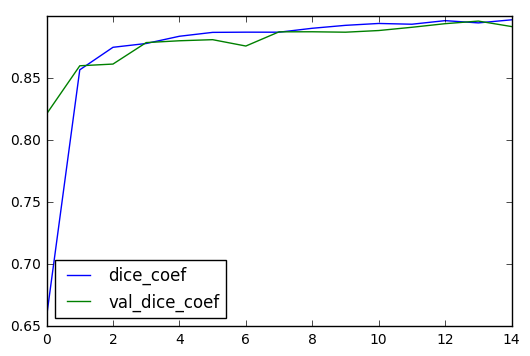

In [27]:
pd.DataFrame(history.history)[['dice_coef', 'val_dice_coef']].plot()

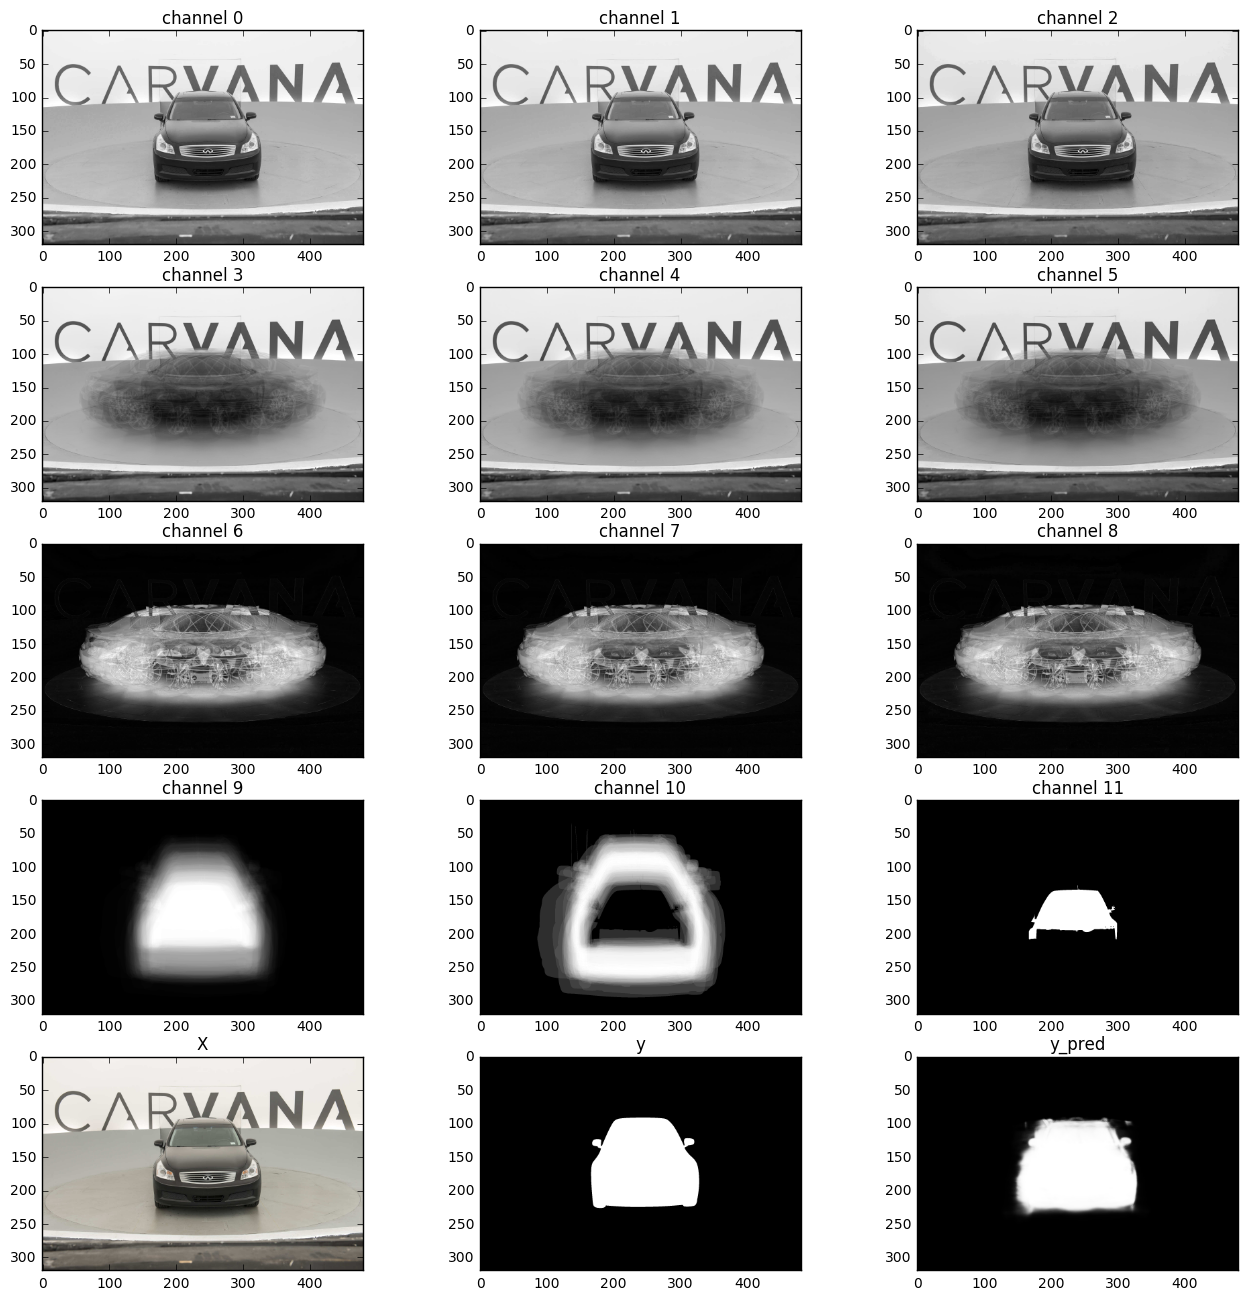

In [30]:
idx = 1
x = X_val[idx]

fig, ax = plt.subplots(5,3, figsize=(16, 16))
ax = ax.ravel()

cmaps = ['Reds', 'Greens', 'Blues']
for i in range(x.shape[-1]):
    ax[i].imshow(x[...,i], cmap='gray') #cmaps[i%3])
    ax[i].set_title('channel {}'.format(i))

ax[-3].imshow((x[...,:3] * X_std[0,...,:3] + X_mean[0,...,:3]) / 255.)
ax[-3].set_title('X')

ax[-2].imshow(y_val[idx,...,0], cmap='gray')
ax[-2].set_title('y')

y_pred = model.predict(x[None]).squeeze()
ax[-1].imshow(y_pred, cmap='gray')
ax[-1].set_title('y_pred')

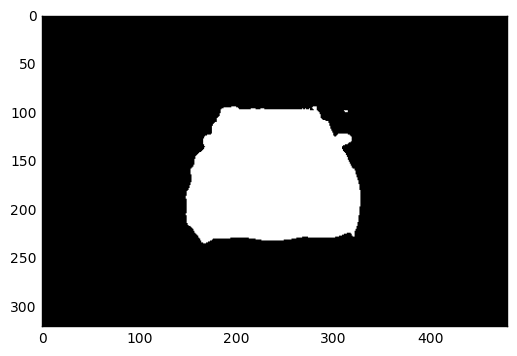

In [31]:
plt.imshow(y_pred > .5, cmap='gray')